# Melanoma Detection Case Study
## Business problem

Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Objective

To build a CNN based model which can accurately detect melanoma. 

**By:**
Cassandra Pratt Romero

### IMPORTANT NOTE
**A VM with GPUs was used to run the notebook. Using Google Colab was only a suggestion**. Paths to dataset will differ from the ones using Google Colab.

Below there are the *variables to update in order to correctly run notebook*. The values differ as for testing different models' architectures original dataset was preserved.

**Before handling class imbalance**

In [ ]:
# Define source path for train data
path_to_train_directory = 'C:\\Users\\UpGradStudent\\Documents\\Dataset\\Train'
# Define source path for test data
path_to_test_directory = 'C:\\Users\\UpGradStudent\\Documents\\Dataset\\Test'

**After handling class imbalance**

In [39]:
# Path to training dataset with rectified class imbalance
# This variable is used for Augmentor
path_to_training_dataset = 'C:\\Users\\UpGradStudent\\Documents\\Dataset\\TrainClassDistribution\\'

In [45]:
# Path to training dataset with rectified class imbalance
# This variable is used to create the datasets
data_dir_train_class = "C:\\Users\\UpGradStudent\\Documents\\Dataset\\TrainClassDistribution"

## Solution structure
- Data Reading/Data Understanding
- Dataset Creation
- Dataset visualisation
- First model building & training
- Data augmentation strategy
    - Model building & training on the augmented data
- Dropout strategy
    - Model building & training with dropout layers
- Class distribution
    - Handling class imbalances
    - Model building & training on the rectified class imbalance data

**Importing all the important libraries**

In [ ]:
import pathlib
import os
from glob import glob

import tensorflow as tf
print('Tensorflow version: ',tf.__version__)
import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib version: ',matplotlib.__version__)
import numpy as np
print('Numpy version: ',np.__version__)
import pandas as pd
print('Pandas version: ',pd.__version__)
import PIL
print('PIL version: ',PIL.__version__)

import Augmentor
print('Augmentor version: ',Augmentor.__version__)

from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

import sklearn
from sklearn.metrics import accuracy_score
print('SKLearn version: ',sklearn.__version__)

import warnings
warnings.filterwarnings('ignore') # Ignore warning messages

Tensorflow version:  2.9.1
Matplotlib version:  3.5.1
Numpy version:  1.21.5
Pandas version:  1.4.2
PIL version:  9.0.1
Augmentor version:  0.2.10
SKLearn version:  1.0.2


## Data Reading/Data Understanding

The **dataset** consists of **2,357 images of malignant and benign oncological diseases**, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following **diseases**:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing Skin Cancer Data

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

**Technical information** about dataset:
- The dataset contains 9 sub-directories in each train and test subdirectories. 
- The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

Let's take a look into each train and test datasets' number of files

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Total images in train dataset: ',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Total images in test dataset: ',image_count_test)

print('Total images: ',image_count_train+image_count_test)

Total images in train dataset:  2239
Total images in test dataset:  118
Total images:  2357


## Dataset creation

Let's load these images off disk using the helpful image_dataset_from_directory utility from keras.preprocessing.

Let's define some parameters for the loader.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

We will use **80%** of the images for **training**, and **20%** for **validation**.

In [ ]:
# Define train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory (
                data_dir_train,
                seed             = seed,
                validation_split = 0.2,
                subset           = 'training',
                image_size       = (img_height,img_width),
                batch_size       = batch_size
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Define validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory (
             data_dir_train,
             seed             = seed,
             validation_split = 0.2,
             subset           = 'validation',
             image_size       = (img_height,img_width),
             batch_size       = batch_size
         )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [77]:
# Define test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory (
              data_dir_test,
              image_size = (img_height, img_width),
              batch_size = batch_size,
              shuffle = False
          )

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Dataset visualisation
Let's print an image of each class of melanoma.

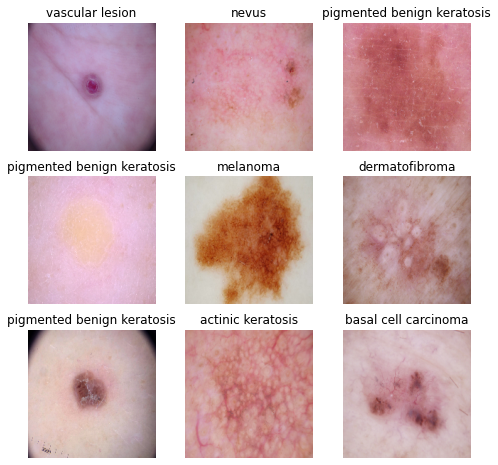

In [ ]:
plt.figure(figsize=(8, 8))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model building and training

### Rescaling the values
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 

In [ ]:
input_shape = (img_height,img_width,3)
num_classes = 9    # Corresponding to 9 classes of skin cancer to 

In [ ]:
# Define sequential model
model = Sequential()

# Add the rescaling layers
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# First CNN unit
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second CNN unit
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Third CNN unit
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
We'll use Adam optimizer as it rectifies vanishing learning rate and converges rapidly. For loss we'll compute the cross-entropy loss with sparse_categorical_crossentropy.

In [ ]:
# Compile model with chosen optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 37s 543ms/step - loss: 2.0917 - accuracy: 0.2087 - val_loss: 1.9850 - val_accuracy: 0.2148
Epoch 2/20
56/56 [==============================] - 29s 513ms/step - loss: 1.6963 - accuracy: 0.3968 - val_loss: 1.5126 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 29s 518ms/step - loss: 1.4856 - accuracy: 0.4994 - val_loss: 1.5750 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 28s 505ms/step - loss: 1.3773 - accuracy: 0.5145 - val_loss: 1.4111 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 28s 503ms/step - loss: 1.2583 - accuracy: 0.5558 - val_loss: 1.3265 - val_accuracy: 0.5593
Epoch 6/20
56/56 [==============================] - 28s 496ms/step - loss: 1.2319 - accuracy: 0.5692 - val_loss: 1.4126 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 28s 501ms/step - loss: 1.1070 - accuracy: 0.6083 - val_loss: 1.3527 - val_accuracy: 0.5369

### Visualize training results

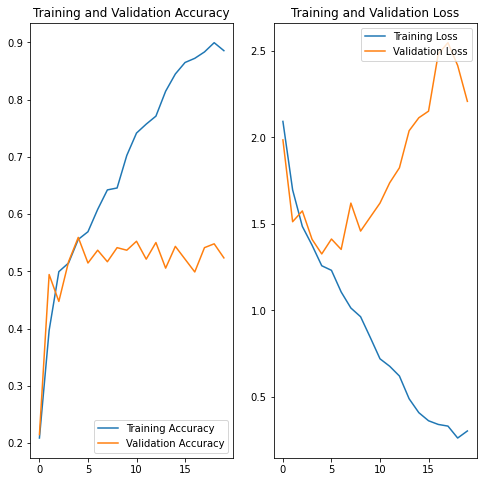

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

We can see that **train accuracy is kept high** in every epoch while the **validation one** grows up but very low in comparison. The validation loss increases.

The **accuracy** of the model in the final epoch for the **training set is really high at ~88%**, while the **validation accuracy** is only at **~52%**. The **training loss** is **low** (0.30) and the **validation loss** is **high** (2.20).

This is an **indicative of overfit** in the model and can be treated in different ways. We can start by augmenting the data set.

## Data augmentation strategy

*Data augmentation* is the technique of increasing the size of data used for training a model. 
As augmentation strategy we'll randomly flip images horizontally or vertically with a random rotation.

In [19]:
# Define data augmentation strategy
data_augmentation = tf.keras.Sequential([
                      keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                      keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect')
                    ])

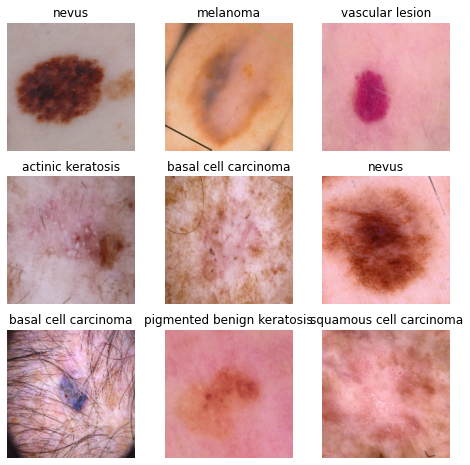

In [20]:
# Visualize how augmentation strategy works for one instance of training image
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

### Model building & training on the augmented data

In [26]:
# Define sequential model with augmented data
model = Sequential([data_augmentation])

# Add the rescaling layers
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# First CNN unit
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second CNN unit
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Third CNN unit
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Compile the model

In [27]:
# Compile model with chosen optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.build((32,180,180,3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 180, 180, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 90, 90, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 90, 90, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 45, 45, 32)         0         
 2D)                                                  

#### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 33s 573ms/step - loss: 2.1580 - accuracy: 0.1931 - val_loss: 2.0312 - val_accuracy: 0.1588
Epoch 2/20
56/56 [==============================] - 31s 552ms/step - loss: 1.8419 - accuracy: 0.3209 - val_loss: 1.7240 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 30s 541ms/step - loss: 1.6222 - accuracy: 0.4096 - val_loss: 1.4863 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 31s 561ms/step - loss: 1.4299 - accuracy: 0.4961 - val_loss: 1.4572 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 30s 533ms/step - loss: 1.4052 - accuracy: 0.5078 - val_loss: 1.4083 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 30s 534ms/step - loss: 1.3464 - accuracy: 0.5190 - val_loss: 1.3771 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 30s 529ms/step - loss: 1.2943 - accuracy: 0.5374 - val_loss: 1.4198 - val_accuracy: 0.5101

#### Visualize the results

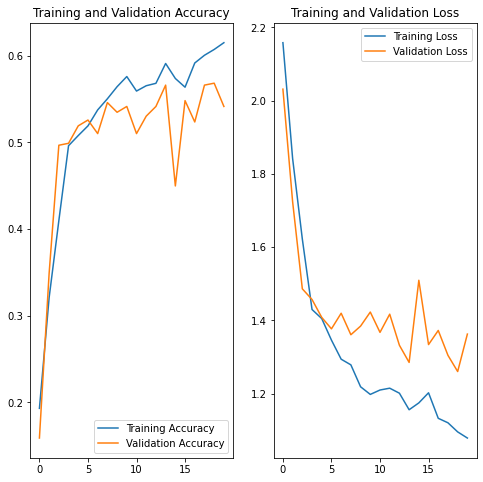

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the train accuracy and validation accuracy are kept closer in every epoch than with first model, with lower values than with first model.

The **accuracy** of the model in the final epoch for the **training set is ~61%**, while the **validation accuracy** is **~54%**. The **training loss** is a little bit greater than first model (1.07) but the **validation loss** is smaller (1.36), which is preferred.

This is an indicative of **overfit decreasing** in the model. Also, as **loss in decreasing for both** data sets, model can still be trained to make better predictions.

**Data augmentation has improved the model performance but not the overall accuracy**. We'll check now a dropout strategy to see if we can improve overfitting.

## Dropout strategy
We'll add **Dropout layer** after data augmentation test to improve general accuracy (avoid overfitting as much as possible).

### Model building & training with dropout layers

In [31]:
# Define sequential model with augmented data
model = Sequential([data_augmentation])

# Add the rescaling layers
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# First CNN unit
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Second CNN unit
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Third CNN unit
#model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))

# Flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Compile the model
Since dropout is implemented in its "inverted" version, we should **lower the learning rate in order to overcome the "boost"** that the dropout probability gives to the learning rate.

In [32]:
# Define optimizer
custom_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [33]:
# Compile model with chosen optimizer
model.compile(optimizer=custom_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model.build((32,180,180,3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 90, 90, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 90, 90, 32)          0         
                                                                 
 conv2d_10 (Conv2D)          (32, 90, 90, 64)          18496     
                                                      

#### Train the model

To **avoid falling into a local minima** we'll define a learning rate reduction "rule": whenever there are 3 consecutive epochs with no improvement in validation accuracy, we'll reduce the learning rate.

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
                            monitor='val_accuracy', 
                            patience=3, 
                            verbose=1, 
                            factor=0.5, 
                            min_lr=0.00001
                          )

In [36]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/20
56/56 [==============================] - 52s 912ms/step - loss: 2.7967 - accuracy: 0.1970 - val_loss: 1.9633 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 50s 888ms/step - loss: 1.9393 - accuracy: 0.2740 - val_loss: 1.8736 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 49s 870ms/step - loss: 1.8475 - accuracy: 0.3354 - val_loss: 1.7322 - val_accuracy: 0.3937 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 49s 882ms/step - loss: 1.7628 - accuracy: 0.3622 - val_loss: 1.7480 - val_accuracy: 0.4385 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 49s 868ms/step - loss: 1.7176 - accuracy: 0.3689 - val_loss: 1.7378 - val_accuracy: 0.3803 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 48s 865ms/step - loss: 1.6602 - accuracy: 0.4129 - val_loss: 1.5488 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 49s 877ms/st

#### Visualize the results

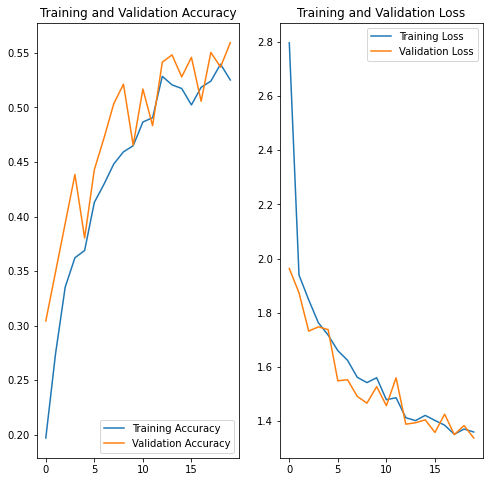

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that validation accuracy was in average higher in every epoch than with second model, but with lower values in general.

The **accuracy** of the model in the final epoch for the **training set is ~53%**, while the **validation accuracy** is **~56%**. The **training loss** is a little bit greater than first model (1.35) as well as the **validation loss** (1.33), but similar.

This is an indicative of **overfit decreasing** in the model. Also, as **loss in decreasing for both** data sets, model can still be trained to make better predictions.

**Dropout has improved the model performance (avoiding overfitting) but not the overall accuracy** (the accuracy drop down drastically). 

**Learning rate reduction rule** has helped in maintaining a decent value for the validation accuracy.

As data augmentation seemed to work better for accuracy, we'll check now if handling class imbalance improves it.

## Class distribution

Many times real life datasets can have *class imbalance*, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

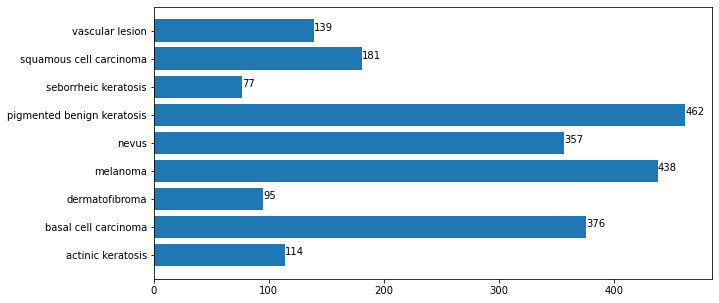

In [38]:
# Count samples by class
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

# Bar plot with samples by class
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)

ax.barh(class_names, count)

for index, value in enumerate(count):
    ax.text(value, index,
             str(value))
plt.show()

**Which class has the least number of samples?** *seborrheic keratosis* has the least number of samples.

**Which classes dominate the data in terms of proportionate number of samples?** *pigmented benign keratosis* and *melanoma* dominate the data. *nevus* and *basal cell carcinoma* come next with proportionate number of samples.

We clearly have an **imbalanced dataset**.

### Handling class imbalance
We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


**Note:**: Below code has already run for latest model tests.

In [ ]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Let's take a look at total count of augmented images.

In [40]:
data_dir_train_output = pathlib.Path(path_to_training_dataset)

In [41]:
image_count_train = len(list(data_dir_train_output.glob('*/output/*.jpg')))
print('Added images for training data: ', image_count_train)

Added images for training data:  4500


Let's see the **distribution of augmented data after adding new images** to the original training data.

In [42]:
path_list   = []
lesion_list = []

# Count images in original path
for i in class_names:
    for j in data_dir_train_output.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
# Count images in output path
for i in class_names:
    for j in data_dir_train_output.glob(i+'/*/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
        
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

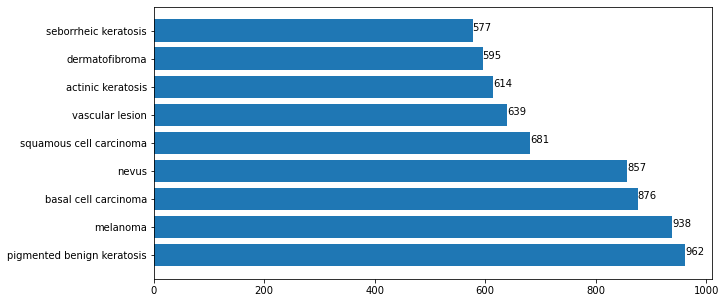

In [43]:
# Plot values by class
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
ax.barh(new_df['Label'].value_counts().index,new_df['Label'].value_counts().to_list())
for index, value in enumerate((new_df['Label'].value_counts()).to_list()):
    ax.text(value, index,
             str(value))
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Model building & training on the rectified class imbalance data

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [46]:
train_ds_class = tf.keras.preprocessing.image_dataset_from_directory(
              data_dir_train_class,
              seed=123,
              validation_split = 0.2,
              subset = 'training',
              image_size=(img_height, img_width),
              batch_size=batch_size
           )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [47]:
val_ds_class = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train_class,
            seed=123,
            validation_split = 0.2,
            subset = 'validation',
            image_size=(img_height, img_width),
            batch_size=batch_size
         )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [48]:
# Define sequential model with augmented data
model = Sequential()

# Add the rescaling layers
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# First CNN unit
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Second CNN unit
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Third CNN unit
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Compile the model

In [49]:
# Define optimizer
custom_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [50]:
# Compile model with chosen optimizer
model.compile(optimizer=custom_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### Train the model

In [52]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
                            monitor='val_accuracy', 
                            patience=3, 
                            verbose=1, 
                            factor=0.5, 
                            min_lr=0.00001
                          )

In [53]:
epochs = 50
history = model.fit(
  train_ds_class,
  validation_data=val_ds_class,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/50
169/169 [==============================] - 112s 652ms/step - loss: 2.1610 - accuracy: 0.1838 - val_loss: 1.9487 - val_accuracy: 0.2413 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 109s 642ms/step - loss: 1.7216 - accuracy: 0.3359 - val_loss: 1.5526 - val_accuracy: 0.4091 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 110s 645ms/step - loss: 1.5722 - accuracy: 0.3917 - val_loss: 1.4531 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 109s 641ms/step - loss: 1.5009 - accuracy: 0.4173 - val_loss: 1.3846 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 110s 649ms/step - loss: 1.4336 - accuracy: 0.4414 - val_loss: 1.2859 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 108s 636ms/step - loss: 1.3950 - accuracy: 0.4586 - val_loss: 1.2926 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 7/50
169/169 [==========================

#### Visualize the model results

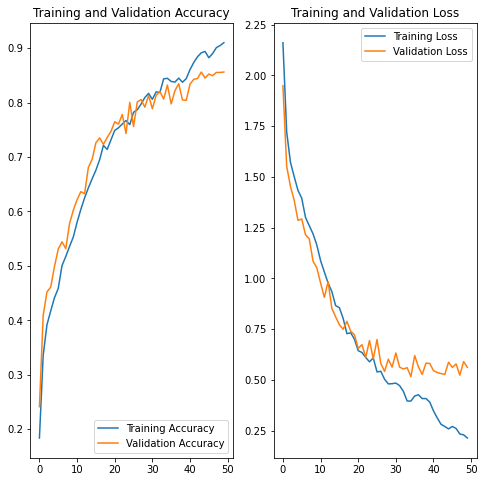

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the train accuracy and validation accuracy are kept closer in every epoch than with previous model, and accuracy increased.

The **accuracy** of the model in the final epoch for the **training set is ~91%**, while the **validation accuracy** is **~86%**. The **loss** for both data sets is less than 1.

This is an indicative of **overfit decreasing** in the model. **Class rebalance has improved the model performance and the accuracy**.

Also, as **loss in decreasing for both** data sets, model could still be trained to make better predictions. 

Much **better models could be built** or tested **using more epochs and/or more layers of different types** (convolution, dropout, batch normalization).

## Conclusions
- Data augmentation strategies and handling class imbalance are a must to improve a model accuracy.
- Dropout strategy improves model performance (reduces overfitting) but might not be enough to improve accuracy.
- Tuning a model for an specific dataset implies testing different combinations of layers and epochs.

## Optional: Model prediction on test data
Now we are ready to do predictions on test data, for which we'll use the model.predict() command.

In [85]:
# Predict on test dataset
prediction = model.predict(test_ds)

4/4 [==============================] - 2s 639ms/step


In [86]:
class_names_test = test_ds.class_names

In [87]:
# Save class predictions on y_pred
y_pred = []
for pred in prediction:
    pred_list = pred.tolist()
    max_pred = max(pred_list)
    class_index = pred_list.index(max_pred)
    y_pred.append(class_names_test[class_index])

In [88]:
# Save original class on y_test
path_list_test   = []
lesion_list_test = []

# Count images in original path
for i in class_names:
    for j in data_dir_test.glob(i+'/*.jpg'):
        path_list_test.append(str(j))
        lesion_list_test.append(i)
        
dataframe_dict_test = dict(zip(path_list_test, lesion_list_test))
df_test = pd.DataFrame(list(dataframe_dict_test.items()),columns = ['Path','y_test'])

df_test['y_pred'] = y_pred

df_test = df_test[['y_test','y_pred']]

In [89]:
df_test.head()

,y_test,y_pred
0,actinic keratosis,seborrheic keratosis
1,actinic keratosis,nevus
2,actinic keratosis,nevus
3,actinic keratosis,nevus
4,actinic keratosis,nevus


Let's check the **model accuracy** on test data set.

In [90]:
print('Test accuracy: ',accuracy_score(df_test['y_test'], df_test['y_pred']))

Test accuracy:  0.3728813559322034


Let's print out the **predictions for 'melanoma' class**.

In [91]:
df_test[df_test['y_test']=='melanoma']

,y_test,y_pred
48,melanoma,nevus
49,melanoma,pigmented benign keratosis
50,melanoma,nevus
51,melanoma,nevus
52,melanoma,nevus
53,melanoma,nevus
54,melanoma,melanoma
55,melanoma,melanoma
56,melanoma,nevus
57,melanoma,pigmented benign keratosis


We can see we have a low general accuracy of 37.28%, while for melanoma class is only 12.5%.

Much **better models could be built** or tested **using more epochs and/or more layers of different types** (convolution, dropout, batch normalization).